In [1]:
import json
import numpy as np
import pandas as pd
import os 
from os import walk
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import shutil
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout, Flatten, Conv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Directories**

In [3]:
Train_path='/content/drive/MyDrive/Defect_inspection/Train/train/'
Val_path='/content/drive/MyDrive/Defect_inspection/Val/val/'
Test_path='/content/drive/MyDrive/Defect_inspection/Test/test/'

**Flow data from directory to tf Dataset**

how much should we resize image?

In [33]:
Batch_Size=64
Img_Siz=255

In [34]:

train_dataset = tf.keras.utils.image_dataset_from_directory(Train_path,
                                                            shuffle=True,
                                                            batch_size=Batch_Size,
                                                            image_size=(Img_Siz,Img_Siz))


Found 23276 files belonging to 2 classes.


In [35]:
val_dataset= tf.keras.utils.image_dataset_from_directory(Val_path,
                                                            batch_size=Batch_Size,
                                                            image_size=(Img_Siz,Img_Siz))


Found 4988 files belonging to 2 classes.


In [36]:
test_dataset= tf.keras.utils.image_dataset_from_directory(Test_path,
                                                            batch_size=Batch_Size,
                                                            image_size=(Img_Siz,Img_Siz))

Found 4990 files belonging to 2 classes.


In [12]:
class_names=train_dataset.class_names

**Visualize Samples**

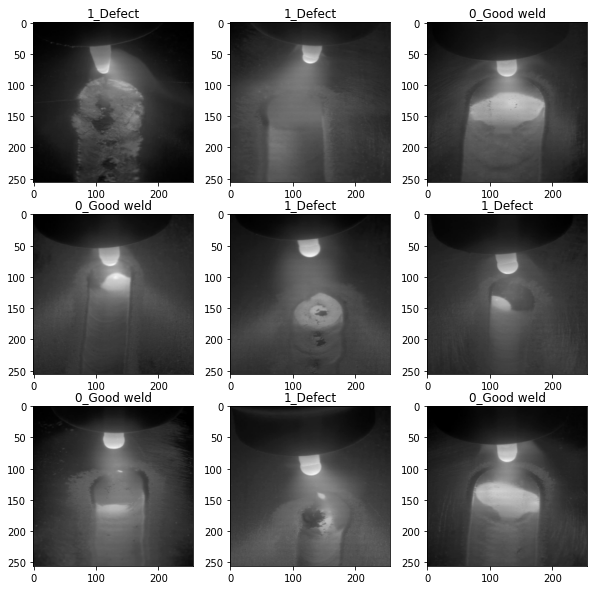

In [13]:
plt.figure(figsize=(10,10))
for image,label in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])



For more optimized and efficient data pipeline

In [17]:
AUTOTUNE=tf.data.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset=val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset=test_dataset.prefetch(buffer_size=AUTOTUNE)

**data augmentation**

In [18]:
Data_augmentation=tf.keras.Sequential(
    [tf.keras.layers.RandomFlip('horizontal'),
     tf.keras.layers.RandomRotation(0.3)]
)

**Visualize Augmentation**

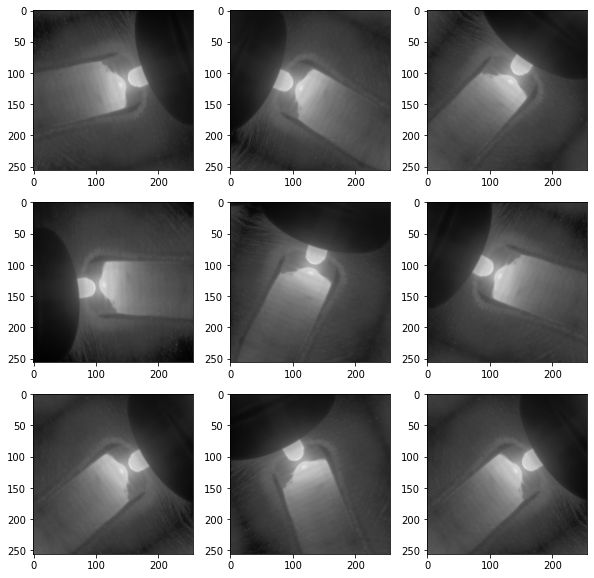

In [20]:
plt.figure(figsize=(10,10))
for image,_ in train_dataset.take(1):
  rand_img=image[0]
  for i in range(9):
    plt.subplot(3,3,i+1)
    aug_images=Data_augmentation(tf.expand_dims(rand_img,0))
    plt.imshow(aug_images[0]/255.0)

**How to treat data imbalance?**

1-class weighting during training

2-Focal loss

3-oversampling

4-undersampling

**VGG-16 (Base_line_Model)**

In [37]:
base_model = tf.keras.applications.VGG16(input_shape=(Img_Siz,Img_Siz,3),
                                               include_top=False,
                                               weights='imagenet')

In [39]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 512)


In [40]:
base_model.trainable = False

In [41]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [43]:
feature_batch_average.shape

TensorShape([64, 512])

In [51]:
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

In [45]:
prediction_batch.shape

TensorShape([64, 1])

**Full Model**

In [52]:
inputs = tf.keras.Input(shape=(Img_Siz, Img_Siz, 3))
x = Data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [50]:
from focal_loss import BinaryFocalLoss

In [53]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy'])

**Model Weighting**

In [55]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
364/364 [==============================] - 293s 793ms/step - loss: 0.0670 - accuracy: 0.8904 - val_loss: 0.0550 - val_accuracy: 0.9102
Epoch 2/10
364/364 [==============================] - 285s 769ms/step - loss: 0.0637 - accuracy: 0.8974 - val_loss: 0.0529 - val_accuracy: 0.9140
Epoch 3/10
364/364 [==============================] - 284s 767ms/step - loss: 0.0603 - accuracy: 0.9044 - val_loss: 0.0504 - val_accuracy: 0.9202
Epoch 4/10
364/364 [==============================] - 285s 770ms/step - loss: 0.0581 - accuracy: 0.9064 - val_loss: 0.0493 - val_accuracy: 0.9210
Epoch 5/10
364/364 [==============================] - 283s 766ms/step - loss: 0.0555 - accuracy: 0.9108 - val_loss: 0.0474 - val_accuracy: 0.9234
Epoch 6/10
 60/364 [===>..........................] - ETA: 3:17 - loss: 0.0514 - accuracy: 0.9172

KeyboardInterrupt: ignored

In [56]:
loss0, accuracy0 = model.evaluate(test_dataset)

78/78 [==============================] - 1658s 19s/step - loss: 0.0447 - accuracy: 0.9325


In [57]:
model.save('Model_93.h5')